<a href="https://colab.research.google.com/github/jiin124/Dacon/blob/main/%ED%95%AD%EA%B3%B5%EC%82%AC%20%EA%B3%A0%EA%B0%9D%20%EB%A7%8C%EC%A1%B1%EB%8F%84%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EB%A7%88%EC%9D%98_%EB%B2%BD_9_4%EB%A5%BC_%EB%84%98%EC%9D%80_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%91%EA%B7%BC%EB%B2%95_XGB%2C_LGBM%2C_CAT%2C_ET_(0_942)_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 마의 벽 9.4를 넘은 데이터 접근법 / XGB, LGBM, CAT, ET (0.942)

lastdefiance20님 코드 필사하면서 공부하기
https://dacon.io/competitions/official/235871/codeshare/4494?page=1&dtype=recent


In [92]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [93]:
train=pd.read_csv('/content/drive/MyDrive/airline_dataset/train.csv')
test=pd.read_csv('/content/drive/MyDrive/airline_dataset/test.csv')
sample=pd.read_csv('/content/drive/MyDrive/airline_dataset/sample_submission.csv')

In [94]:
train.head(1).transpose()

,0
id,1
Gender,Female
Customer Type,disloyal Customer
Age,22
Type of Travel,Business travel
Class,Eco
Flight Distance,1599
Seat comfort,3
Departure/Arrival time convenient,0
Food and drink,3


## 데이터 훒어보기

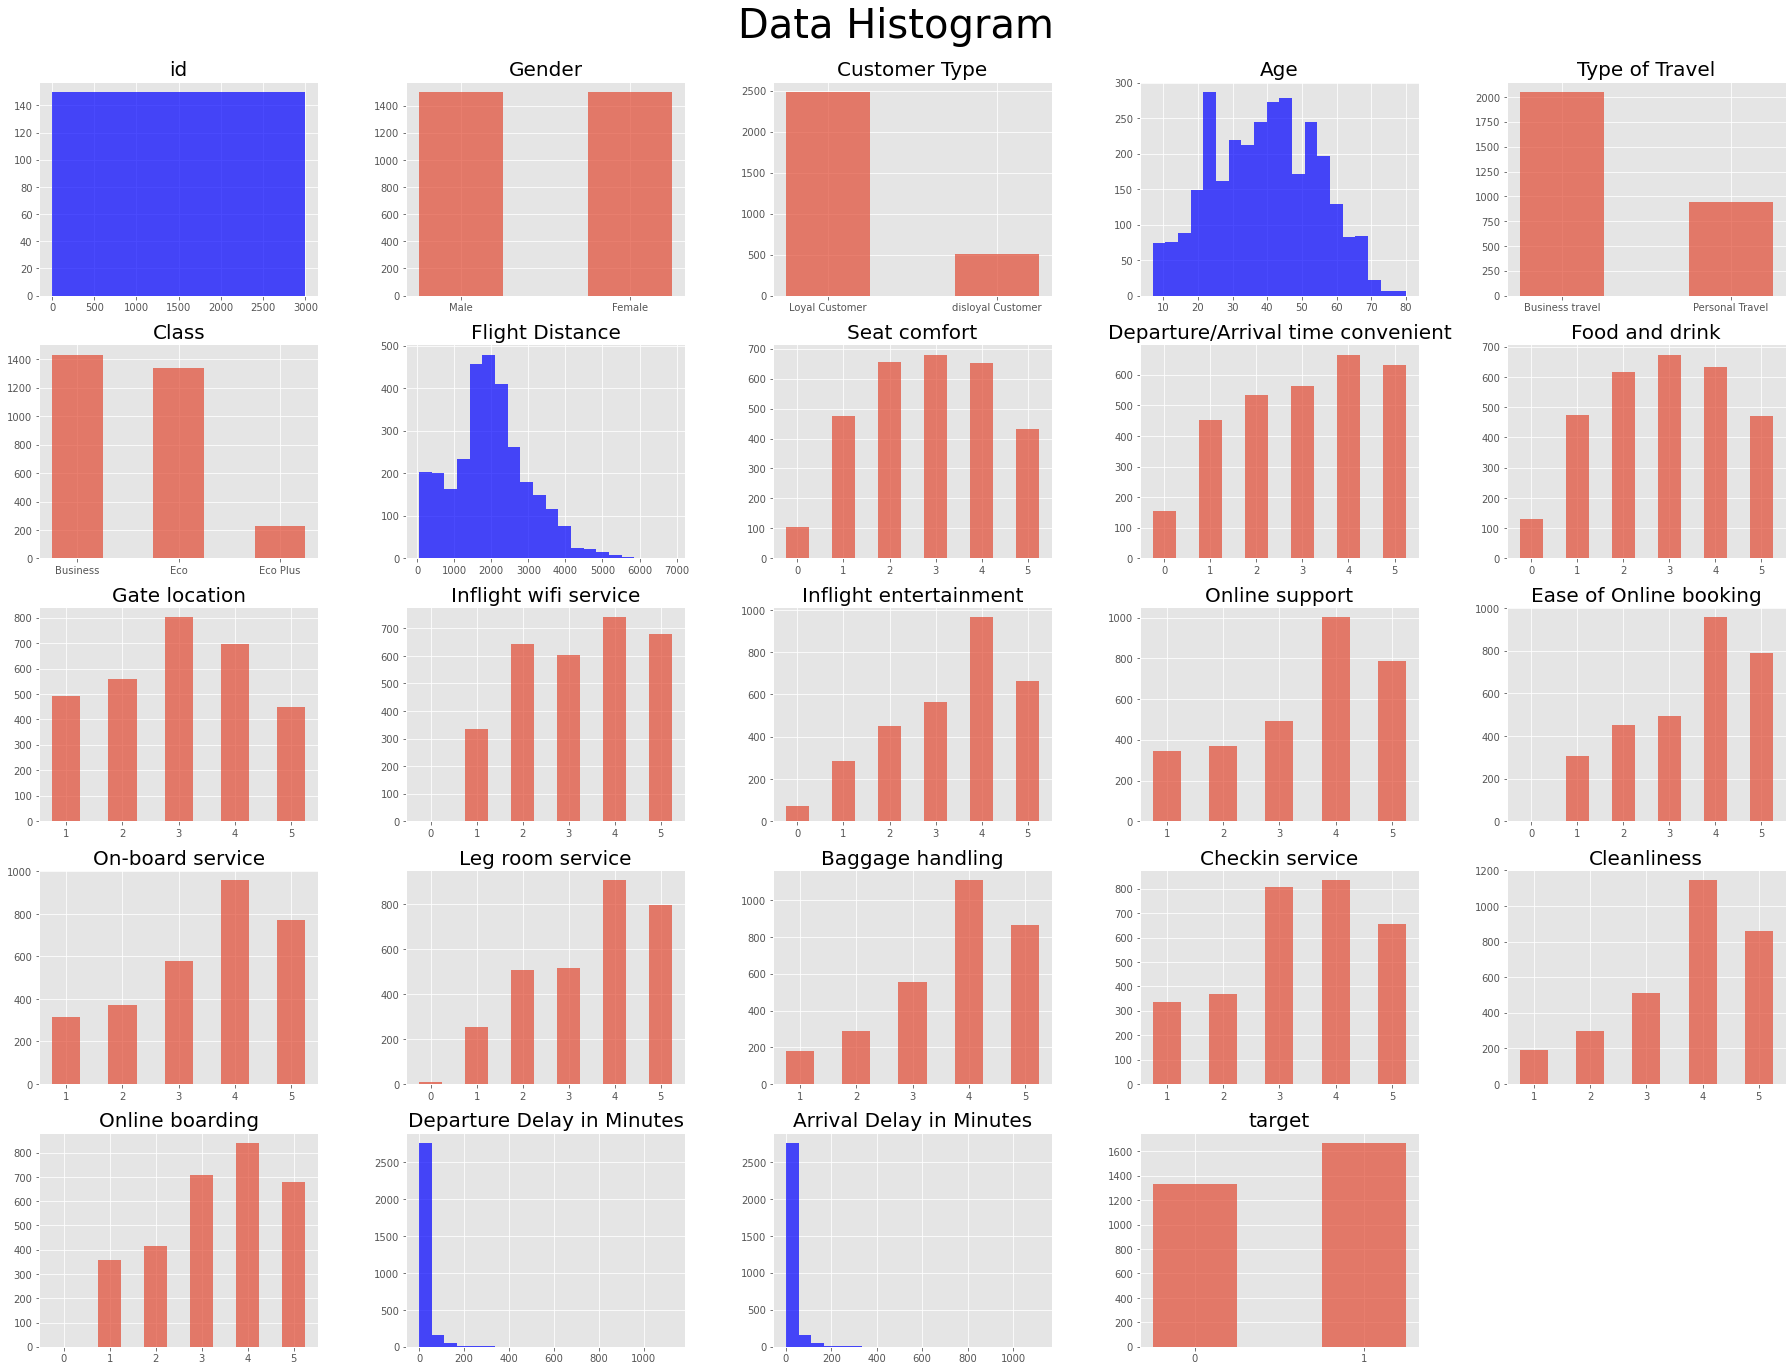

In [4]:
plt.style.use('ggplot')

#히스토그램을 사용해 데이터의 분포를 살핀다. 
plt.figure(figsize=(25,20))
plt.suptitle('Data Histogram',fontsize=40)

#id는 제외하고 시각화
cols=train.columns

for i in range(len(cols)):
  plt.subplot(5,5,i+1)
  plt.title(cols[i],fontsize=20)
  if len(train[cols[i]].unique())>20:
    plt.hist(train[cols[i]],bins=20,color='b',alpha=0.7)
  else:
    temp=train[cols[i]].value_counts()
    plt.bar(temp.keys(),temp.values,width=0.5,alpha=0.7)
    plt.xticks(temp.keys())


plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

데이터를 훓어볼 때 살펴보는 것
- 데이터의 분포가 상대적으로 매우 적은지 -> 매우 적다면 범주를 합치거나 하는 등의 변환이 필요
- 데이터의 분포가 극단적으로 치우쳐져 있는지 -> log변환 등의 방법을 통해 정규화 해주는 작업이 필요

1. flight distance,departure delay in minutes, arrival delay in minutes 등의 그래프가 왼쪽으로 치우쳐져 있다는 점. 
2. leg room service 등 1~5를 가진 feature 중에서 0 값의 분포가 매우 적다는 점. 

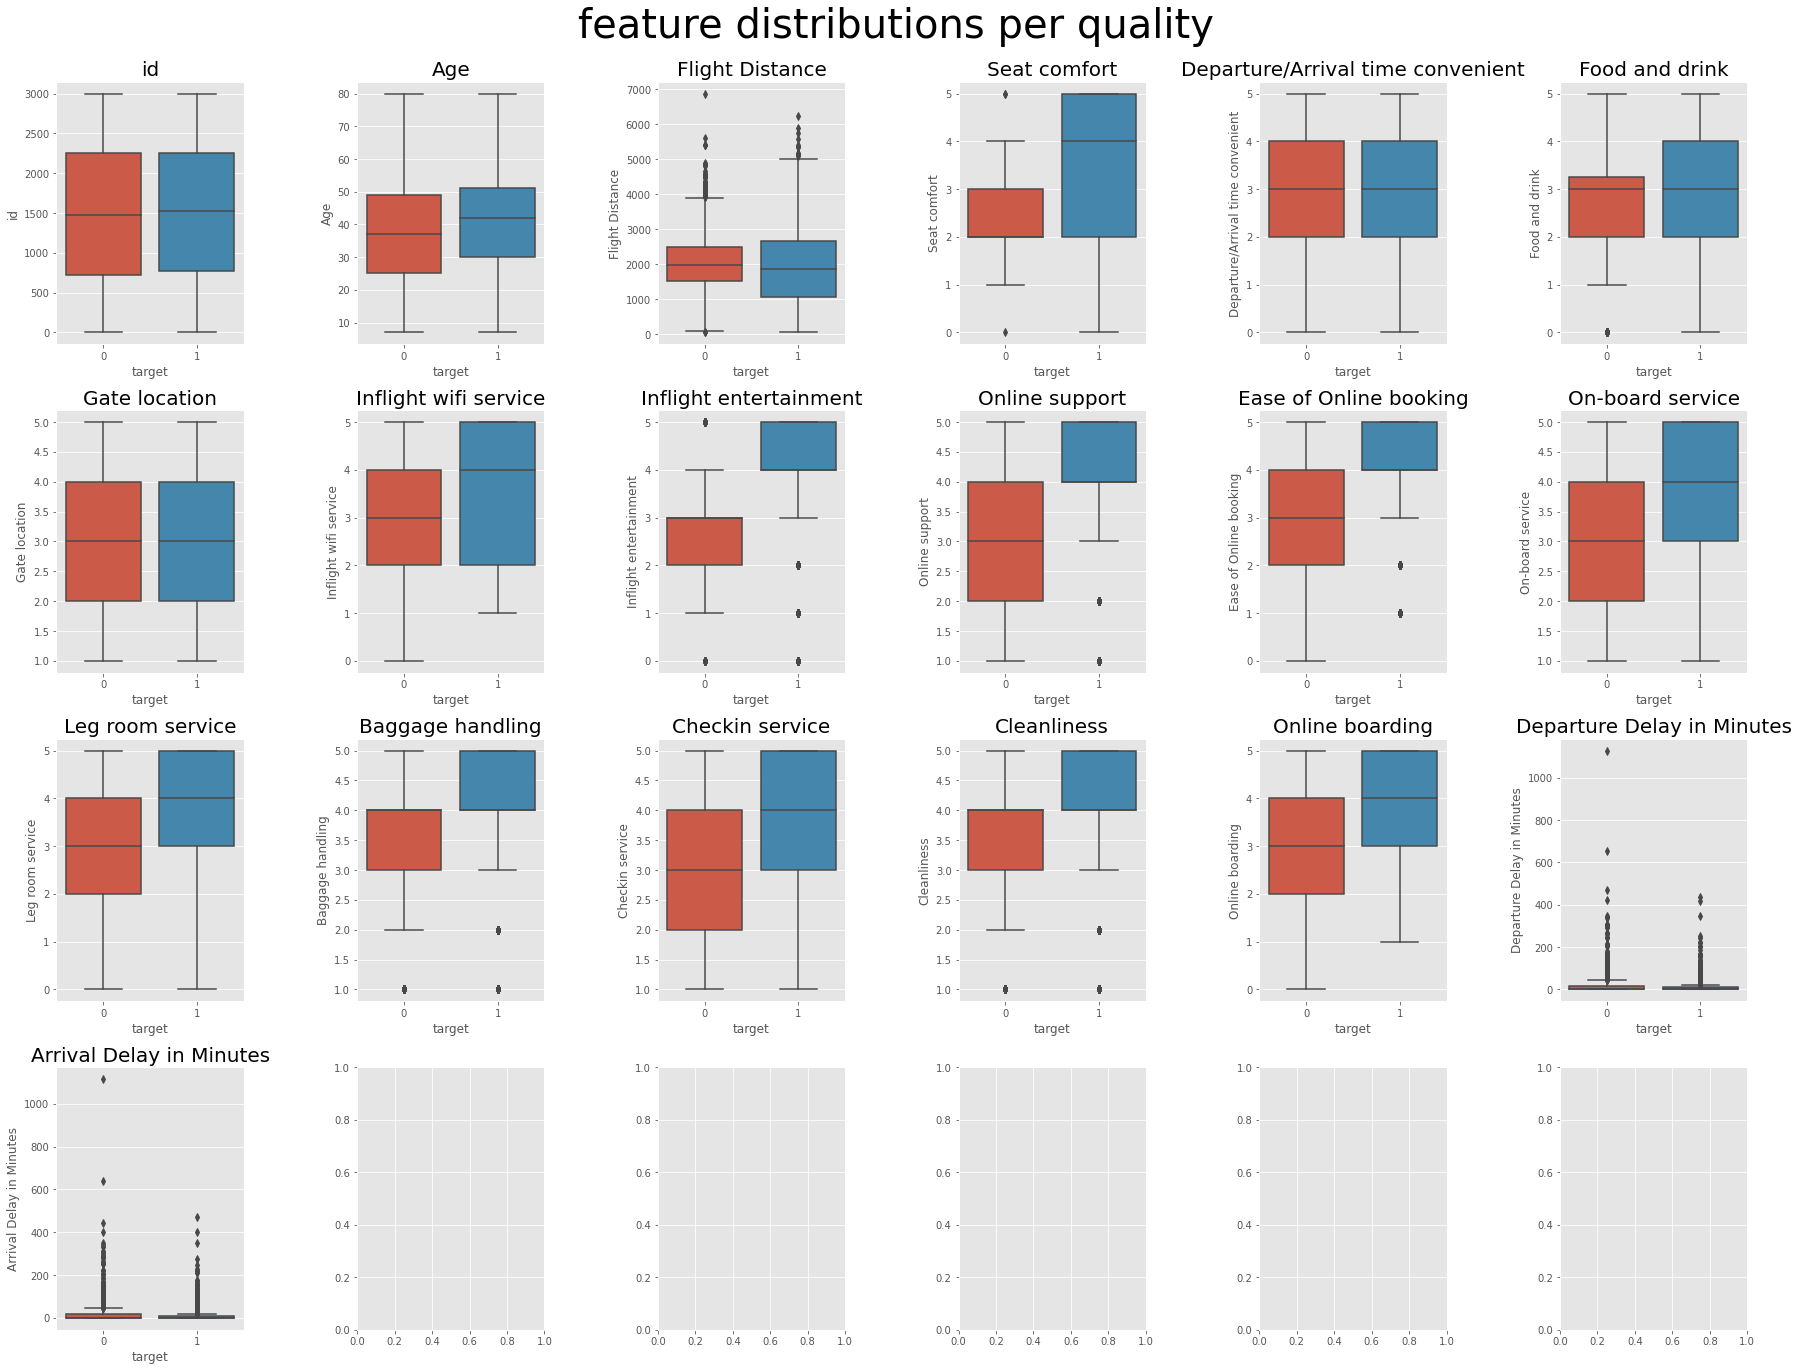

In [5]:
#수치형 데이터 분리
numeric_feature=train.columns[(train.dtypes=='int64')|(train.dtypes=='float')]
num_data=train[numeric_feature]

#박스플롯
fig,axes=plt.subplots(4,6,figsize=(25,20))

fig.suptitle('feature distributions per quality',fontsize=40)

for ax,col in zip(axes.flat,num_data.columns[:-1]):
  sns.boxplot(x='target',y=col,ax=ax,data=num_data)
  ax.set_title(col,fontsize=20)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

## 데이터 분류하기

데이터의 속성에 따라서 numeric,ordinal,categorical로 나누어 분류

In [6]:
train.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
       'Food and drink', 'Gate location', 'Inflight wifi service',
       'Inflight entertainment', 'Online support', 'Ease of Online booking',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'target'],
      dtype='object')

In [95]:
numeric_feature = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_feature = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
           'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 
           'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

categorical_feature = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

## 데이터 훑어보기

feature/target 그래프로 target과 feature의 관계 확인

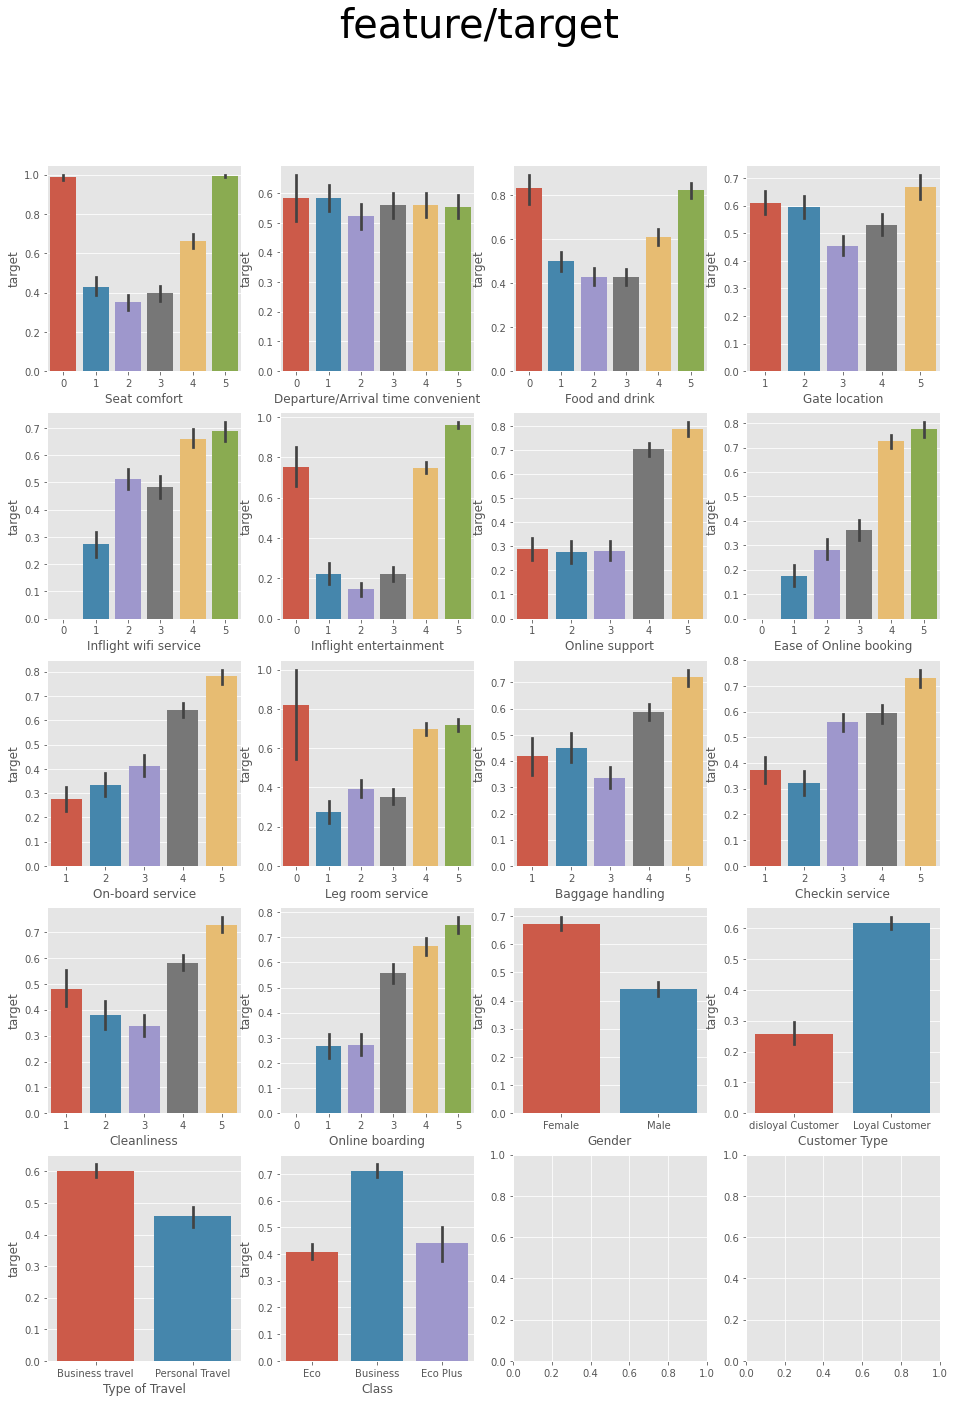

In [8]:
fig,ax=plt.subplots(5,4,figsize=(16,22))

plt.suptitle('feature/target',fontsize=40)

feature=ordinal_feature+categorical_feature

xvalue=0
yvalue=0

for xstr in feature:
  sns.barplot(x=xstr,y='target',data=train,ax=ax[yvalue][xvalue])

  if xvalue==3:
    xvalue=0
    yvalue+=1
  else:
    xvalue+=1

여기서 주목할 점은 0에서 5로 이루어진 ordinal feature 데이터에서 0의 의미. 

0에서 5의 범위를 우리가 만족도라고 생각할 경우 0은 매우 나쁨. 5는 매우좋음이라고 생각할 수 있다. 그래프를 참고하면 5에 가까울수록 전체적인 만족도가 높았다는 것을 의미하며 우리가 구해야할 target 즉 만족을 해 1값이 나올 확률이 높다는 것이다. 그렇다면 0에 가까울 수록 target이 1이 될 확률이 낮아지고, 5에 가까워질수록 target값이 1이 될 확률이 높아져야 한다. 하지만 그래프에서 1에서 5에 해당하는 부분은 예상처럼 값이 증가할수록 target의 확률이 높아지는 양상을 보이고 있지만 0의 경우는 위에서 확인한것처럼 설문한 데이터의 수가 매우 적을 뿐더러 어떨때는 만족도가 5일때보다 target의 확률이 높은 모습을 보여주고 있다. (편차도 매우 심함)

즉. 0은 누락된 결측치나 설문하지 않은 값을 모두 nan 대신 0이라는 값으로 채워넣었다는 것. 

결론적으로 0을 데이터의 양이 적다고 1에 합치거나, 0~5로 label encoding을 하여 순서를 부여할 경우 학습에 안좋은 영향을 끼칠 수 있습니다.

따라서 만약 0값이 포함된 ordinal feature로 학습을 진행한다면 label encoding보다는 one-hot encoding을 이용하여 0에 의미를 부여하지 않는 것이 중요해 보입니다.

## 데이터 정제하기

- 데이터 훑어보기 단계에서 얻은 insight를 바탕으로 데이터 정제하기
- 새로운 feature 만들기
- 데이터 제거하기



### 1. flight distance,departure delay in minutes, arrival delay in minutes 그래프가 왼쪽으로 치우쳐져 있다는 점

log변환

In [9]:
#치우쳐진 정도=skewness 
for xstr in numeric_feature:
  print(xstr,"Scew",train[xstr].skew())

Age Scew 0.0010456925943488839
Flight Distance Scew 0.4509930169224059
Departure Delay in Minutes Scew 9.190139679910239
Arrival Delay in Minutes Scew 8.887761727831762


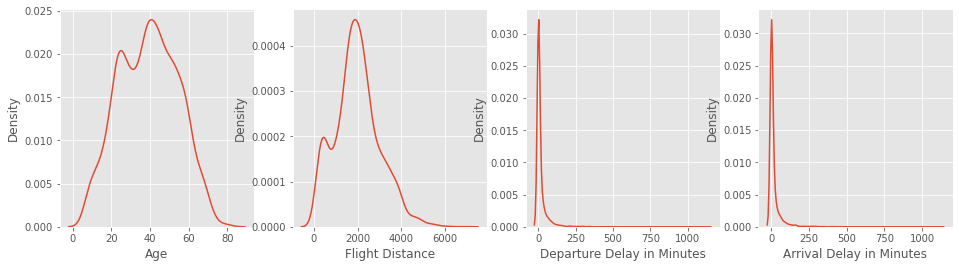

In [10]:
fig,ax=plt.subplots(1,4,figsize=(16,4))

for xint in range(4):
  sns.kdeplot(x=numeric_feature[xint],data=train,ax=ax[xint])

Flight Distance는 왜도가 심하지 않기 때문에, Departure Delay in Minutes, Arrival Delay in Minutes만 log변환하겠습니다

In [96]:
train['Departure Delay in Minutes']=np.log1p(train['Departure Delay in Minutes'])
train['Arrival Delay in Minutes']=np.log1p(train['Arrival Delay in Minutes'])

test['Departure Delay in Minutes']=np.log1p(train['Departure Delay in Minutes'])
test['Arrival Delay in Minutes']=np.log1p(test['Arrival Delay in Minutes'])

In [97]:
for xstr in numeric_feature:
  print(xstr,"Scew :",train[xstr].skew())

Age Scew : 0.0010456925943488839
Flight Distance Scew : 0.4509930169224059
Departure Delay in Minutes Scew : 0.9302111175258293
Arrival Delay in Minutes Scew : 0.8979015577156512


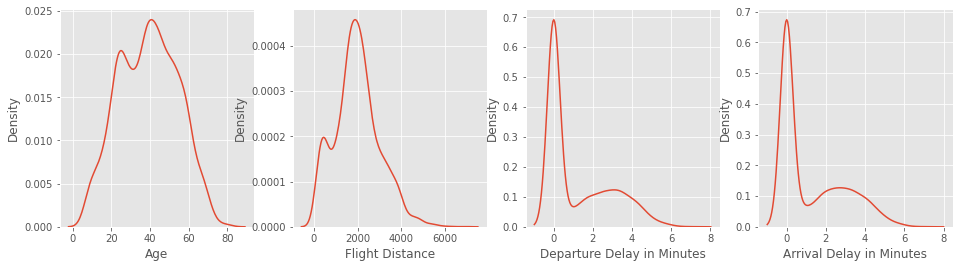

In [98]:
fig,ax=plt.subplots(1,4,figsize=(16,4))

for xint in range(4):
  sns.kdeplot(x=numeric_feature[xint],data=train,ax=ax[xint])

### 2. Leg room service 등 1~5를 가진 feature중에서 0값은 NULL값, 결측치이다.

여기서 결측치라는 것을 인지하고, 대치하지 않는 방법이 있으니 결측치를 최대한 복원해보겠다.

결측치가 적다면 결측치를 대치하여 데이터 복구를 시도해보고 결측치가 많다면 0인 그대로 놔둔호 one-hot encoding을 이용하겠다. 

1~5값을 가진 범주형 데이터 결측치를 대치하기 위해서 딥러닝 기반의 datawig라는 라이브러리를 사용했다. 

In [99]:
print('Train data missing value')
for feature in ordinal_feature:
  if len(train[train[feature]==0])>0:
    print(feature,len(train[train[feature]==0]))

print('===================================')


print('Test data missing value')
for feature in ordinal_feature:
  if len(test[test[feature]==0])>0:
    print(feature,len(test[test[feature]==0]))

Train data missing value
Seat comfort 106
Departure/Arrival time convenient 154
Food and drink 129
Inflight wifi service 2
Inflight entertainment 73
Ease of Online booking 1
Leg room service 11
Online boarding 1
Test data missing value
Seat comfort 64
Departure/Arrival time convenient 90
Food and drink 80
Inflight wifi service 1
Inflight entertainment 39
Leg room service 10


여기서 수가 20개 이하로 적은 친구들만 datawig를 이용해 대치한 결과가 가장 좋았다.

### online booking and boarding

우선 train data에만 Ease of Online Booking과 Online boarding의 결측치가 1개 있기 때문에 이 부분은 train data만 간단하게 수정해줍니다.

In [100]:
corr_matrix=train.corr()
corr_matrix['Online boarding'].sort_values(ascending=False)[:5]

Online boarding           1.000000
Ease of Online booking    0.684511
Online support            0.675139
Inflight wifi service     0.632049
Inflight entertainment    0.353772
Name: Online boarding, dtype: float64

Ease of online booking 과 online boarding은 online support 와 상관관계가 높고 상식적으로도 둘 모두가 online support 라는 범주안에 해당한다고 생각하기 때문에 online support값으로 대치해준다. 

In [101]:
train['Ease of Online booking'][train['Ease of Online booking']==0]=3
train['Online boarding'][train['Online boarding']==0]=3

datawig를 통해 대치하기 위해 0 값을 np.nan으로 바꿔준다. 

In [102]:
for i in range(len(train)):
  for feature in ordinal_feature:
    if train[feature].iloc[i]==0:
      train[feature].iloc[i]=np.nan

for i in range(len(test)):
  for feature in ordinal_feature:
    if test[feature].iloc[i]==0:
      test[feature].iloc[i]=np.nan

### inflight wifi service

상관관계가 높은 3개의 feature를 선정하고 datawig를 이용해 학습시킨뒤 train과 test셋의 결측치를 대치

In [103]:
corr_matrix=train.corr()
corr_matrix['Inflight wifi service'].sort_values(ascending=False)[:5]

Inflight wifi service     1.000000
Online boarding           0.630754
Ease of Online booking    0.602117
Online support            0.562900
Inflight entertainment    0.290907
Name: Inflight wifi service, dtype: float64

In [104]:
train.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
       'Food and drink', 'Gate location', 'Inflight wifi service',
       'Inflight entertainment', 'Online support', 'Ease of Online booking',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'target'],
      dtype='object')

In [105]:
pip install datawig

In [106]:
import datawig

target_feature='Inflight wifi service'

imputer=datawig.SimpleImputer(input_columns=['Online boarding','Ease of Online booking','Online support'],
                              output_column=target_feature)
imputer.fit(train_df=train,num_epochs=50)

null_train=train[train[target_feature].isnull()]
null_imputed=imputer.predict(null_train)
imputed_train=pd.DataFrame(null_imputed)

n=0
for i in range(len(train)):
  if np.isnan(train[target_feature].iloc[i])==True:
    train[feature].iloc[i]=int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
    n+=1

null_train=test[test[target_feature].isnull()]
null_imputed=imputer.predict(null_train)
imputed_train=pd.DataFrame(null_imputed)

n=0
for i in range(len(test)):
  if np.isnan(test[target_feature].iloc[i])==True:
    test[target_feature].iloc[i]=int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
    n+=1

### Leg room service

상관관계가 높은 3개의 feature를 선정하고 datawig를 이용해 학습시킨 뒤 train test의 결측치를 대치

In [107]:
corr_matrix=train.corr()
corr_matrix['Inflight wifi service'].sort_values(ascending=False)[:5]

Inflight wifi service     1.000000
Online boarding           0.630754
Ease of Online booking    0.602117
Online support            0.562900
Inflight entertainment    0.290907
Name: Inflight wifi service, dtype: float64

In [108]:
import datawig

target_feature='Leg room service'

imputer=datawig.SimpleImputer(input_columns=['Baggage handling','On-board service','Cleanliness'],
                              output_column=target_feature)
imputer.fit(train_df=train,num_epochs=50)

null_train=train[train[target_feature].isnull()]
null_imputed=imputer.predict(null_train)
imputed_train=pd.DataFrame(null_imputed)

n=0
for i in range(len(train)):
  if np.isnan(train[target_feature].iloc[i])==True:
    train[target_feature].iloc[i]=int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
    n+=1

null_train=test[test[target_feature].isnull()]
null_imputed=imputer.predict(null_train)
imputed_train=pd.DataFrame(null_imputed)

n=0
for i in range(len(test)):
  if np.isnan(test[target_feature].iloc[i])==True:
    test[target_feature].iloc[i]=int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
    n+=1



In [109]:
for feature in ordinal_feature:
  if train[feature].isnull().sum()>0:
    print(feature,train[feature].isnull().sum())

print('==========================')

for feature in ordinal_feature:
  if test[feature].isnull().sum()>0:
    print(feature,test[feature].isnull().sum())

Seat comfort 106
Departure/Arrival time convenient 154
Food and drink 129
Inflight wifi service 2
Inflight entertainment 73
Seat comfort 64
Departure/Arrival time convenient 90
Food and drink 80
Inflight entertainment 39


나머지는 건드리지 않는다. 이 4개의 feature는 많은 결측치를 가지고 있기 떄문에 될수 있다면 제거하는게 좋아보인다. 

## 새로운 feature 만들기

Arrival Delay in Minutes는 분으로 된 numeric feature이기 때문에 1분 지연과 지연없음에 대한 차이가 적게 나타납니다. 따라서 조금이라도 시간이 지연되었다면 사람들의 만족도가 크게 떨어졌을거라고 가정하고 지연된 부분이 있는지 / 없는지에 대한 boolean 변수를 하나 추가하여 딜레이가 있었는지 / 없었는지에 대한 feature를 생성하였습니다.



In [110]:
train['Delayed']=(train['Departure Delay in Minutes']
                  +train['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)
test['Delayed']=(test['Departure Delay in Minutes']+
                 test['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)

## 데이터 제거하기

다중공선성을 위해 제거

- id : 학습에 관련없음
- departure delay in minutes-arrival delay in minutes과의 다중공선성과 target과의 낮은 상관계수
- food and drink - seat comfort와의 다중공선성과 많은 결측치
- departure/arrival time convenient - 많은 결측치 및 target과의 낮은 상과계수

In [111]:
corr_matrix=train.corr()
corr_matrix['target'].sort_values(ascending=False)

target                               1.000000
Inflight entertainment               0.601695
Ease of Online booking               0.447450
Online support                       0.411944
Seat comfort                         0.372013
On-board service                     0.359699
Online boarding                      0.350508
Leg room service                     0.320374
Checkin service                      0.248975
Inflight wifi service                0.241177
Cleanliness                          0.234848
Baggage handling                     0.232302
Food and drink                       0.219507
Age                                  0.107226
Delayed                              0.097188
id                                   0.007544
Gate location                        0.003213
Departure/Arrival time convenient   -0.005230
Flight Distance                     -0.052059
Departure Delay in Minutes          -0.105554
Arrival Delay in Minutes            -0.142003
Name: target, dtype: float64

In [112]:

train = train.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)
test = test.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)

### object 형식 int로 바꾸기

In [113]:
cat_cols=train.select_dtypes('object').columns.tolist()
cat_cols

['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [114]:
from sklearn.preprocessing import LabelEncoder

la=LabelEncoder()

for i in cat_cols:
  train[i]=la.fit_transform(train[i].values.reshape(-1,1))
  test[i]=la.transform(test[i].values.reshape(-1,1))

display(train.head())
print()
display(test.head())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  Returns
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  -------


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,target,Delayed
0,0,1,22,0,1,1599,3.0,3,4.0,3.0,4,4,5,4.0,4,4,5,4,0.000000,0,1
1,0,0,37,0,0,2810,2.0,4,1.0,4.0,3,5,5,4.0,2,1,5,2,2.944439,0,0
2,1,0,46,0,0,2622,1.0,1,4.0,5.0,5,4,4,4.0,4,5,4,3,0.000000,1,1
3,0,1,24,0,1,2348,3.0,3,3.0,3.0,3,3,2,4.0,5,3,4,3,1.098612,0,0
4,0,0,58,0,0,105,3.0,3,4.0,4.0,5,4,4,4.0,4,4,4,5,0.000000,1,1


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,Delayed
0,0,0,61,1,1,2037,1.0,1,3.0,5.0,5,5,5,5.0,5,3,5,3,4.077537,0
1,0,1,27,0,0,1846,1.0,4,1.0,1.0,1,1,3,4.0,5,4,4,1,0.000000,0
2,0,0,52,0,0,1622,4.0,4,4.0,3.0,4,5,5,5.0,5,4,5,3,0.000000,1
3,1,0,54,0,0,3534,4.0,4,5.0,4.0,5,2,2,2.0,2,5,2,1,0.000000,0
4,0,0,41,0,1,1471,4.0,3,4.0,4.0,4,4,3,1.0,2,5,4,4,0.000000,1


In [115]:
X_train=train.drop('target',axis=1)
y_train=train['target']
X_test=test

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
Gender                      3000 non-null int64
Customer Type               3000 non-null int64
Age                         3000 non-null int64
Type of Travel              3000 non-null int64
Class                       3000 non-null int64
Flight Distance             3000 non-null int64
Seat comfort                2894 non-null float64
Gate location               3000 non-null int64
Inflight wifi service       2998 non-null float64
Inflight entertainment      2927 non-null float64
Online support              3000 non-null int64
Ease of Online booking      3000 non-null int64
On-board service            3000 non-null int64
Leg room service            3000 non-null float64
Baggage handling            3000 non-null int64
Checkin service             3000 non-null int64
Cleanliness                 3000 non-null int64
Online boarding             3000 non-null int64
Arrival Delay in Minu

## 모델 학습하기

빠르게 다양한 결과를 시도해보기 위해 pycaret을 사용해 모델을 선정하고 학습

가장 성능이 높은 LGBM,CatBoost, XGBoost 3가지를 이용한 소프트 보팅을 이용했음

In [ ]:
pip install pycaret

In [ ]:
from pycaret.classification import *

clf1=setup(data=train,
           silent=True,
           target='target',
           session_id=20201809,
           n_jobs=7)

In [ ]:
pip install catboost

In [117]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

estimators=[]

lgbm=LGBMClassifier()
estimators.append(lgbm)

xgb=XGBClassifier()
estimators.append(xgb)

cat=CatBoostClassifier()
estimators.append(cat)

#모듈의 파라미터들을 할당할 리스트 만들어주기
params=[]

params_lgbm={
    'n_estimators':[90,100,200,300],
    'min_samples_split':[1,2,3,4],
    'learning_rate':[0.05,0.1,0.5],
    'max_depth':[2,3,4]
}
params.append(params_lgbm)

params_xgb={'n_estimatros':[100,300,500],
            'learning_rate':[0.05,0.1,0.3],
            'max_depth':[3,5,7],
            'subsample':[0.1,0.3]}

params.append(params_xgb)

params_cat={
    'learning_rate':[0.05,0.1,0.3]
}
params.append(params_cat)

In [122]:
from tqdm.auto import tqdm

def gridSearchCV(models,params):
  best_models=[]

  for i in tqdm(range(0,len(models))):
    model_grid=GridSearchCV(models[i],params[i],n_jobs=-1,verbose=1,cv=5)
    model_grid.fit(X_train,y_train)
    best_models.append(model_grid.best_estimator_)
  return best_models

best_model_list=gridSearchCV(estimators,params)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
exception calling callback for <Future at 0x7f1724ea7890 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/catboost/__init__.py", line 1, in <module>
    from .core import (
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 43, in <module>
    from .plot_helpers import save_plot_fil

Fitting 5 folds for each of 3 candidates, totalling 15 fits


BrokenProcessPool: ignored

In [74]:
best_model_list

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=4,
                min_child_samples=20, min_child_weight=0.001,
                min_samples_split=1, min_split_gain=0.0, n_estimators=300,
                n_jobs=-1, num_leaves=31, objective=None, random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=100,
               n_estimatros=100, n_jobs=1, nthread=None,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=0.

In [ ]:
pip install scikit-learn==0.23.1


In [ ]:
pip install imbalanced-learn==0.7.0

In [119]:
best_models=[
             ('lgbm',LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=4,
                min_child_samples=20, min_child_weight=0.001,
                min_samples_split=1, min_split_gain=0.0, n_estimators=300,
                n_jobs=-1, num_leaves=31, objective=None, random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)),
             ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=100,
               n_estimatros=100, n_jobs=1, nthread=None,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=0.3, verbosity=1)),
             ('cat', CatBoostClassifier())
]


In [ ]:

from sklearn.ensemble import VotingClassifier

voting=VotingClassifier(estimators=best_models)
voting.fit(X_train,y_train)